## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3


In [2]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 236MB/s]


In [3]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=41134705-cfc1-44e6-9475-0615eb1c5156
To: /content/coco_captions.npy
100% 415M/415M [00:02<00:00, 151MB/s]


In [4]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)

In [6]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [7]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [8]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [9]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [10]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [11]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [12]:
def shuffle_data(x,y,y_captions):
    index_array = np.arange(len(x))
    np.random.shuffle(index_array)
    x_shuffled = x[index_array]
    y_shuffled = y[index_array]
    y_captions_shuffled = y_captions[index_array]
    return x_shuffled, y_shuffled, y_captions_shuffled ,index_array

x_shuffled, y_shuffled, y_captions_shuffled ,index_array = shuffle_data(image_embeddings, caption_embeddings, captions_np)
n_train = int(np.floor(x_shuffled.shape[0]*0.8))
x_train, y_train, y_captions_train = x_shuffled[:n_train], y_shuffled[:n_train], y_captions_shuffled[:n_train]
x_test, y_test, y_captions_test = x_shuffled[n_train:], y_shuffled[n_train:], y_captions_shuffled[n_train:]


In [13]:
index = faiss.IndexFlatL2(512)
index.add(x_train)
print(index.is_trained)

True


# Task-1

In [14]:
def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)

    return similarity

def predict(x_test_instance, y_train, y_captions_train, index, k=3):
  D, I = index.search(np.reshape(x_test_instance,(-1,512)), k)
  query_vector = np.zeros(512)
  Z = np.sum(D[0])

  for i in range(len(D[0])):
    similrity_score = 1-(D[0][i]/Z)
    query_vector += np.sum(np.dot(similrity_score, y_train[I[0][i]]) ,axis=0)
  query_vector = (1/(k*5))*query_vector
  all_captions_instances = np.reshape(y_train[I[0]], (-1,512))
  distances = np.array([cosine_similarity(query_vector,caption_emd) for caption_emd in all_captions_instances])
  sorted_idx = np.argsort(distances)
  all_captions_text = y_captions_train[I].flatten()
  prediction = all_captions_text[sorted_idx[-1]]

  return prediction



# Task-2: Trying different k values

In [15]:
accuracies = []
k_values = [3,5,7,10,15,20]
for k in k_values:
  print("k -",k)
  predictions = []
  references = []
  for i,x_test_instance in enumerate(x_test):
      references.append(y_captions_test[i])
      prediction_temp = predict(x_test_instance, y_train, y_captions_train, index, k=k)
      predictions.append(prediction_temp)
  accuracies.append(accuracy(predictions, y_captions_test))


k - 3


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

k - 5
k - 7
k - 10
k - 15
k - 20


Text(0, 0.5, 'Bluescore (%)')

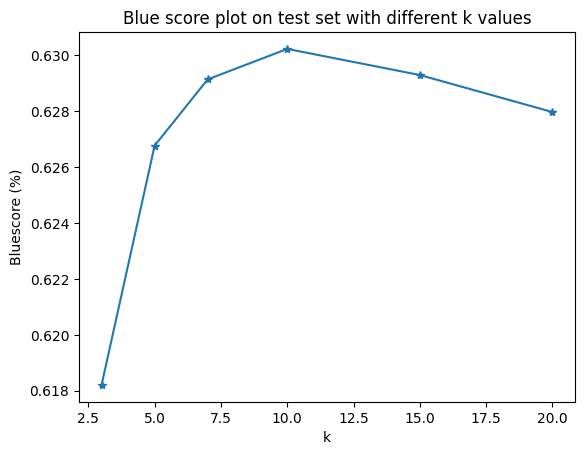

In [16]:
plt.plot(k_values, accuracies,'*-')
plt.title('Blue score plot on test set with different k values')
plt.xlabel('k')
plt.ylabel('Bluescore (%)')

# Obsevations
1. Tried with k values as 3,5,7,10,15,20
2. As k increases accuracy (bluescore) is increasing till k=10 and then decreases
3. From the observation k=10 is the best choice

# Task-3: Few options from faiss index factory

In [17]:
index_factory_strings = ["PCA32,Flat","PCA64,Flat","PCA80,Flat","HNSW32","OPQ16_64,IMI2x8,PQ8+16"]
k = 10
for index_factory_string in index_factory_strings:
  start_time = time.time()
  index = faiss.index_factory(512,index_factory_string)
  index.train(x_train)
  predictions = []
  references = []
  for i,x_test_instance in enumerate(x_test):
      references.append(y_captions_test[i])
      prediction_temp = predict(x_test_instance, y_train, y_captions_train, index, k=k)
      predictions.append(prediction_temp)
  end_time = time.time()
  a = accuracy(predictions, references)
  print("Execution with",index_factory_string,"is",end_time - start_time,"seconds and accuracy is",a)



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Execution with PCA32,Flat is 8.961044788360596 seconds and accuracy is 0.2854263778369141
Execution with PCA64,Flat is 14.976475954055786 seconds and accuracy is 0.2854263778369141
Execution with PCA80,Flat is 8.760933637619019 seconds and accuracy is 0.2854263778369141
Execution with HNSW32 is 6.7913267612457275 seconds and accuracy is 0.2854263778369141
Execution with OPQ16_64,IMI2x8,PQ8+16 is 54.43284559249878 seconds and accuracy is 0.2854263778369141


# Observations
1. It is observed that as number of transofrmation increases more time is taking.
2. Different transformation taking different time.
3. From the tries choices, HNSW32 is the fastest.
4. It is observed that the performance is same with all options tried, but less than the performance with IndexFlatL2 method(Task2 outcome).

# Task-4: Qualitative Study
1. To observe predictions for any test image, please enter some idx number in the below cell and run.
2. It visualised the image, predicted caption and corresponding 5 ground truth captions

In [20]:
index = faiss.IndexFlatL2(512)
index.add(x_train)
predictions = []
references = []
for i,x_test_instance in enumerate(x_test):
    references.append(y_captions_test[i])
    prediction_temp = predict(x_test_instance, y_train, y_captions_train, index, k=10)
    predictions.append(prediction_temp)

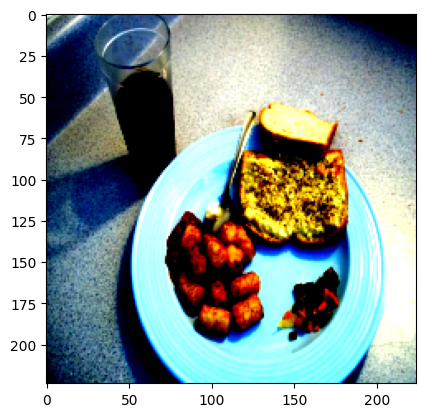

Prediction :  A plate of sandwiches with a drink on the side.
Ground truths:  ['A sandwich with tater tots, ketchup, vegetables and a spoon.', 'A white plate of food with tater tots and a sandwich.', 'A plate of toast, hash browns, and vegetables depicted along side a glass containing a drink.', 'A plate with a sandwich, tater tots, a vegetable mix and a spoon.', 'A plate with hashbrowns and bread and cup and drink.']


In [22]:
# Enter some index to view predictions
idx = 55
img, captions = coco_dset[index_array[n_train+idx]]
image_array = np.transpose(img, (1, 2, 0))
plt.imshow(image_array)
plt.show()
print("Prediction : ",predictions[idx])
print("Ground truths: ",captions)

# Observations
1. It is observed that the predictions are almost matching the ground truth captions and best describes the pictures.
2. Since captions are not generated but choosed from best matchin image, predictions cannot match always.

Prediction :  A washroom with a clean toilet and tub.
Ground truths:  ['A toilet in a bathroom next to a wall.', 'Small bathroom with square toilet and small stand in shower', 'The small bathroom has a beige toilet in it.', 'a toilet in a bath room with a bath tub near by', 'We are looking at a very small bathroom.']
